In [1]:
import cv2
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import urllib.request
from app.utils.dataset import DepthDataset, create_data_loader
from app.utils.env import Env
import matplotlib.pyplot as plt
import cv2

In [2]:
env = Env()

In [3]:

image_size = 256
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.ToPILImage()
])

target_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

dataset = DepthDataset(
    root_dir=env.dataset_path / "val",
    transform=transform,
    target_transform=target_transform,
)

dataloader = create_data_loader(
    dataset,
    batch_size=16,
    num_workers=4,
    shuffle=True
)

In [4]:
raw_image, depth_image = dataset[0]

In [5]:
type(raw_image)

PIL.Image.Image

In [6]:
raw_np = np.array(raw_image)

In [ ]:
model_type = "MiDaS_small"
midas = torch.hub.load("intel-isl/MiDaS", model_type)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.small_transform

In [9]:
raw_np.shape

(256, 256, 3)

In [10]:
input_tensor = transform(raw_np).to(device)

In [11]:
input_tensor.shape

torch.Size([1, 3, 256, 256])

In [12]:
with torch.no_grad():
    prediction = midas(input_tensor)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=raw_np.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze().cpu().numpy()
    

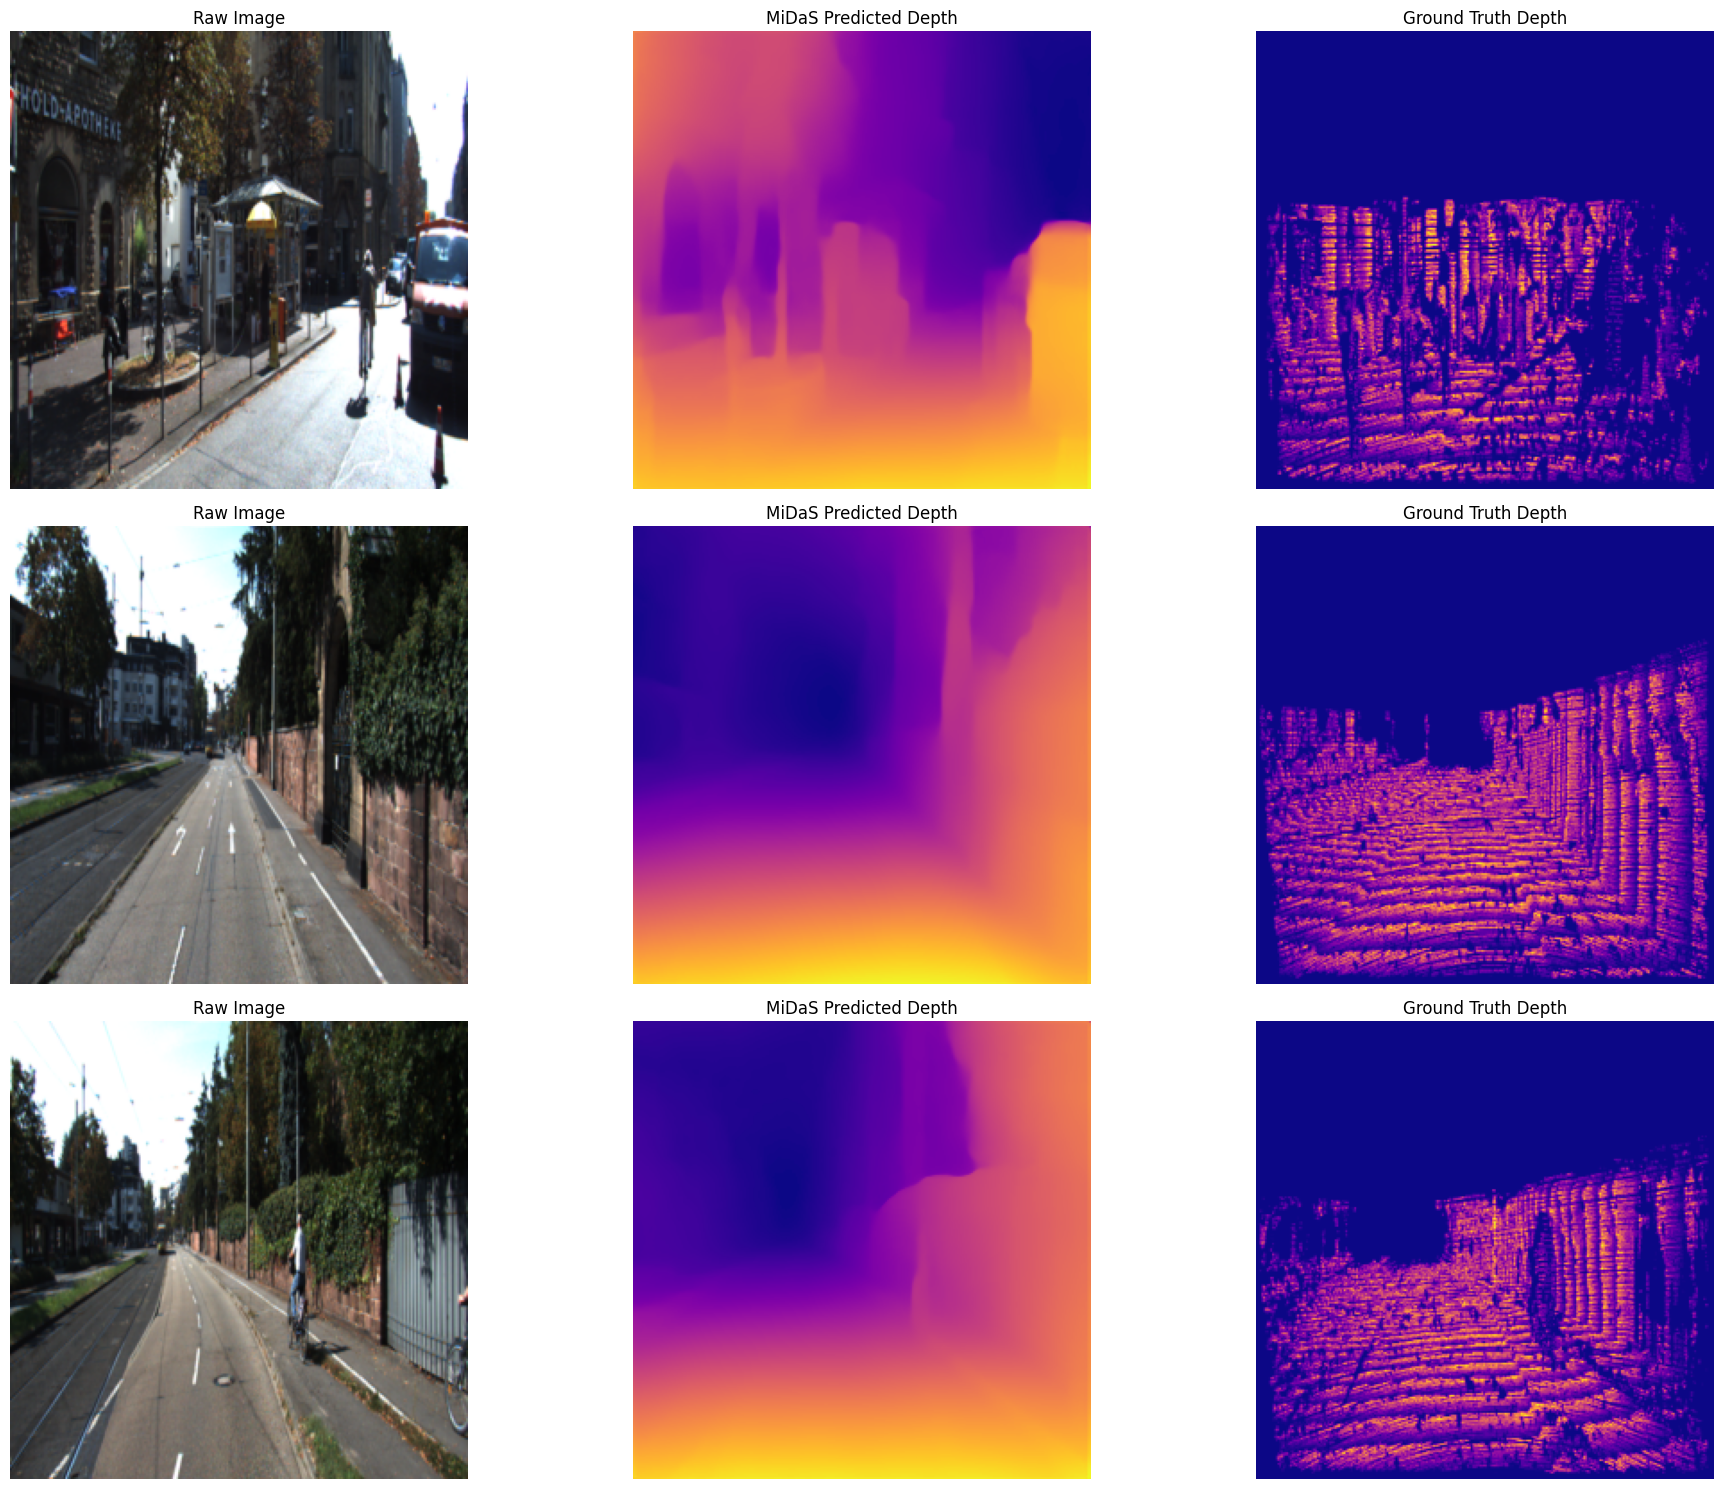

In [19]:
import random
random.seed(23)

num_examples = 3
fig = plt.figure(figsize=(20, 5*num_examples))

for i in range(num_examples):
    idx = random.randint(0, len(dataset)-1)
    raw_image, depth_image = dataset[idx]
    raw_np = np.array(raw_image)
    input_tensor = transform(raw_np).to(device)
    with torch.no_grad():
        prediction = midas(input_tensor)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=raw_np.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze().cpu().numpy()

    ax = fig.add_subplot(num_examples, 3, i*3+1)
    ax.imshow(raw_np, cmap='plasma')
    ax.set_title("Raw Image")
    ax.axis('off')

    ax = fig.add_subplot(num_examples, 3, i*3+2)
    ax.imshow(prediction, cmap='plasma')
    ax.set_title("MiDaS Predicted Depth")
    ax.axis('off')

    ax = fig.add_subplot(num_examples, 3, i*3+3)
    ax.imshow(depth_image.permute(1,2,0).numpy() * 255, cmap='plasma')
    ax.set_title("Ground Truth Depth")
    ax.axis('off')

plt.tight_layout()
plt.show()


    

    


# fig = plt.figure(figsize=(20, 5))
# ax = fig.add_subplot(1, 3, 1)
# ax.imshow(raw_np)
# ax = fig.add_subplot(1, 3, 2)
# ax.imshow(prediction)

# ax = fig.add_subplot(1, 3,3)
# ax.imshow(depth_image.permute(1,2,0).numpy() * 255)

# plt.show()

In [16]:
from transformers import DPTImageProcessor, DPTForDepthEstimation   

In [17]:
image_processor = DPTImageProcessor.from_pretrained("Intel/dpt-hybrid-midas")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas", low_cpu_mem_usage=True)
model.to(device)

DPTForDepthEstimation(
  (dpt): DPTModel(
    (embeddings): DPTViTHybridEmbeddings(
      (backbone): BitBackbone(
        (bit): BitModel(
          (embedder): BitEmbeddings(
            (convolution): WeightStandardizedConv2d(
              3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False
              (pad): DynamicPad2d()
            )
            (pooler): BitMaxPool2d(
              kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False
              (pad): DynamicPad2d()
            )
            (pad): Identity()
            (norm): BitGroupNormActivation(
              32, 64, eps=1e-05, affine=True
              (activation): ReLU()
            )
          )
          (encoder): BitEncoder(
            (stages): ModuleList(
              (0): BitStage(
                (layers): Sequential(
                  (0): BitBottleneckLayer(
                    (downsample): BitDownsampleConv(
                      (conv): WeightStandardizedConv2d(64, 

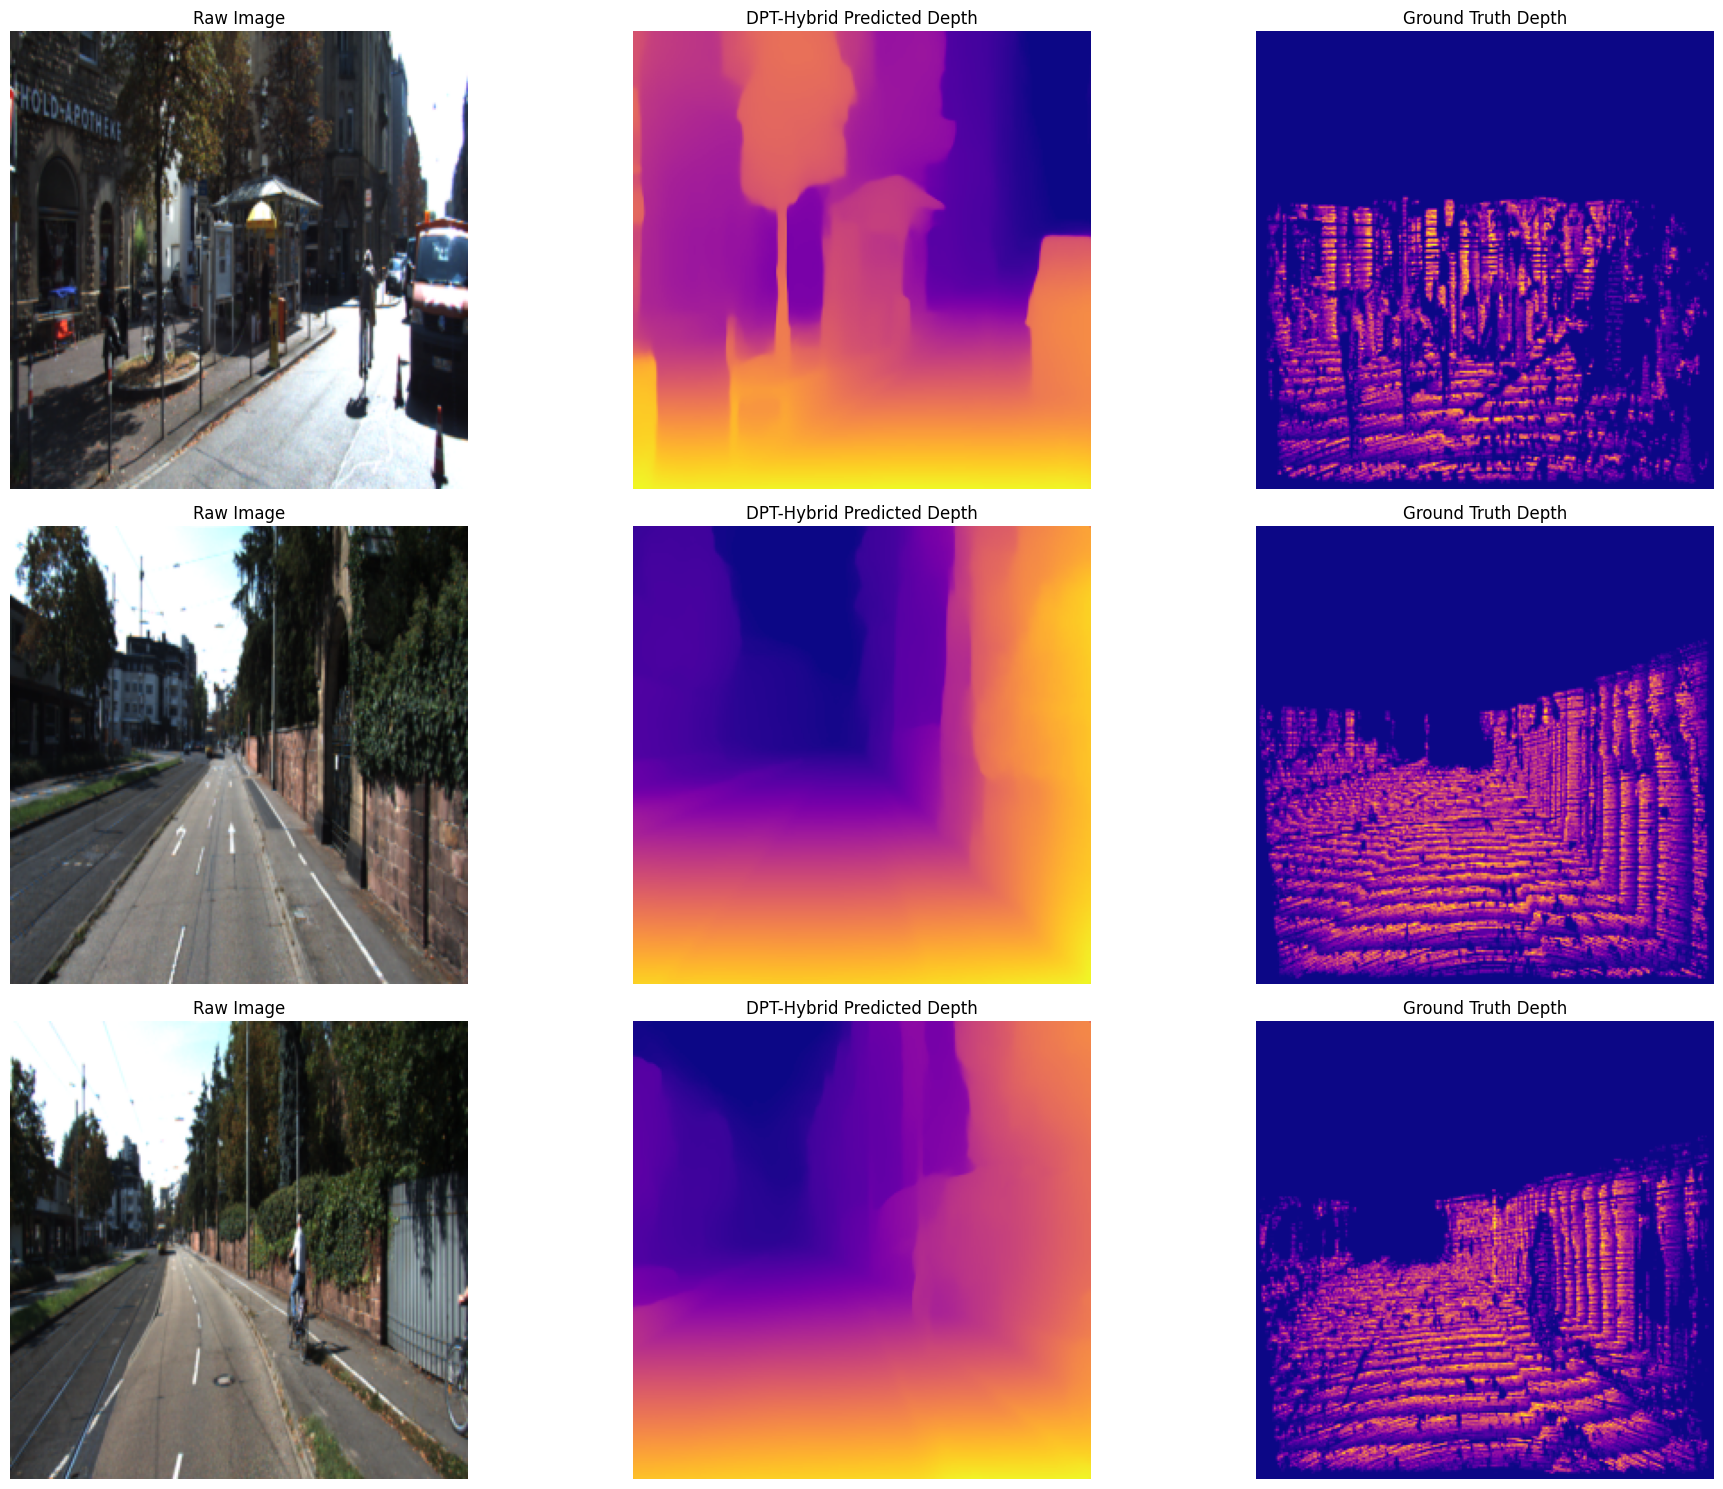

In [20]:
import random
random.seed(23)

num_examples = 3
fig = plt.figure(figsize=(20, 5*num_examples))

for i in range(num_examples):

    idx = random.randint(0, len(dataset)-1)
    raw_image_PIL, depth_image = dataset[idx]
    # raw_image_PIL = transforms.ToPILImage()(raw_image)
    # raw_np = np.array(raw_image_PIL)

    inputs = image_processor(raw_image_PIL, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth

    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=raw_image_PIL.size[::-1],  # (height, width)
        mode="bicubic",
        align_corners=False
    ).squeeze().cpu().numpy()

    # raw_image, _ = val_dataset_raw[idx]

    depth_min = prediction.min()
    depth_max = prediction.max()
    normalized_depth = (prediction - depth_min) / (depth_max - depth_min)

    # apply mask

    mask = depth_image.squeeze().numpy() < 0
    # prediction[mask] = -1

    # prediction[~mask] = (prediction[~mask] - prediction[~mask].min()) / (
    #                 prediction[~mask].max() - prediction[~mask].min())
    # prediction[mask] = 0

    depth_np = depth_image.squeeze().cpu().numpy()
    depth_np[~mask] = (depth_np[~mask] - depth_np[~mask].min()) / (depth_np[~mask].max() - depth_np[~mask].min())
    depth_np[mask] = 0


    ax = fig.add_subplot(num_examples, 3, i*3+1)
    ax.imshow(raw_image_PIL, cmap='plasma')
    ax.set_title("Raw Image")
    ax.axis('off')

    ax = fig.add_subplot(num_examples, 3, i*3+2)
    ax.imshow(normalized_depth, cmap='plasma')
    ax.set_title("DPT-Hybrid Predicted Depth")
    ax.axis('off')

    ax = fig.add_subplot(num_examples, 3, i*3+3)
    ax.imshow(depth_np, cmap='plasma')
    ax.set_title("Ground Truth Depth")  
    ax.axis('off')

plt.tight_layout()
plt.show()


In [17]:
# import requests

# from PIL import Image

# import torch

# from transformers import DepthProImageProcessorFast, DepthProForDepthEstimation

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# image_processor = DepthProImageProcessorFast.from_pretrained("apple/DepthPro-hf")

# model = DepthProForDepthEstimation.from_pretrained("apple/DepthPro-hf").to(device)



In [18]:
# image, _ = dataset[0]

# inputs = image_processor(images=image, return_tensors="pt").to(device)

# with torch.no_grad():

#     outputs = model(**inputs)

# post_processed_output = image_processor.post_process_depth_estimation(

#     outputs, target_sizes=[(image.height, image.width)],

# )

# # field_of_view = post_processed_output[0]["field_of_view"]

# # focal_length = post_processed_output[0]["focal_length"]

# depth = post_processed_output[0]["predicted_depth"]

# depth = (depth - depth.min()) / depth.max()

# depth = depth * 255.

# depth = depth.detach().cpu().numpy()

# depth = Image.fromarray(depth.astype("uint8"))

In [19]:
# display depth with plasma colormap

# plt.imshow(depth, cmap='plasma')

In [20]:

# import random
# random.seed(23)

# num_examples = 1
# fig = plt.figure(figsize=(20, 5*num_examples))

# for i in range(num_examples):

#     idx = random.randint(0, len(dataset)-1)
#     raw_image_PIL, depth_image = dataset[idx]
#     # raw_image_PIL = transforms.ToPILImage()(raw_image)
#     # raw_np = np.array(raw_image_PIL)

#     inputs = image_processor(images=raw_image_PIL, return_tensors="pt").to(device)

#     with torch.no_grad():
#         outputs = model(**inputs)

#     post_processed_output = image_processor.post_process_depth_estimation(
#         outputs, target_sizes=[(raw_image_PIL.height, raw_image_PIL.width)],
#     )

#     depth = post_processed_output[0]["predicted_depth"]

#     depth = (depth - depth.min()) / depth.max()

#     depth = depth * 255.

#     depth = depth.detach().cpu().numpy()

    

#     ax = fig.add_subplot(num_examples, 3, i*3+1)
#     ax.imshow(raw_image_PIL, cmap='plasma')
#     ax.set_title("Raw Image")
#     ax.axis('off')

#     ax = fig.add_subplot(num_examples, 3, i*3+2)
#     ax.imshow(depth, cmap='plasma')
#     ax.set_title("Depth Pro Depth")
#     ax.axis('off')

#     ax = fig.add_subplot(num_examples, 3, i*3+3)
#     ax.imshow(depth_image, cmap='plasma')
#     ax.set_title("Ground Truth Depth")  
#     ax.axis('off')

# plt.tight_layout()
# plt.show()
